<div align="center">

## 쏘카 프로젝트 01: 어떤 예측 모형이 차량 수요 예측에 가장 적합할까?
</div>

**주요 라이브러리 버전 확인**

In [67]:
import pandas
import pmdarima
import statsmodels

print(pandas.__version__)
print(pmdarima.__version__)
print(statsmodels.__version__)

1.2.0
1.8.3
0.12.1


**라이브러리 불러오기**

In [68]:
import os
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
import pmdarima as pm

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools

import warnings
warnings.filterwarnings('ignore')

**데이터 불러오기**

In [69]:
file_path_raws = os.getenv('HOME') + '/aiffel/demand_forecasting/data/raws.csv'
df_raws = pd.read_csv(file_path_raws)

In [70]:
df_raws_sort=df_raws.sort_values('target_dates')
display(df_raws_sort.head())

,target_dates,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
396,2019-09-08,0.381038,0.134719,0.095673,0.081302,0.073248,0.067846,0.059269,0.050881,0.392379,...,3850,1190,0,18.8,24.4,9,2019,36,6,True
569,2019-09-09,0.294693,0.094521,0.058669,0.049279,0.040270,0.033519,0.029069,0.024346,0.316189,...,2392,1777,0,90.4,24.7,9,2019,37,0,False
529,2019-09-10,0.327382,0.115586,0.065420,0.050327,0.043757,0.035807,0.030258,0.026159,0.359647,...,2827,2526,0,127.7,24.9,9,2019,37,1,False
117,2019-09-11,0.382523,0.149016,0.094511,0.073380,0.062836,0.055696,0.048563,0.043774,0.409784,...,5867,5083,0,98.4,24.1,9,2019,37,2,False
107,2019-09-12,0.559916,0.266497,0.201238,0.166553,0.143653,0.130768,0.119568,0.106934,0.568754,...,9692,9838,0,38.8,21.3,9,2019,37,3,False


### Step 1. 학습 데이터와 테스트 데이터 나누기

In [71]:
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

_x_data.set_index("target_dates", drop=True, inplace=True)
_x_data = _x_data.sort_values('target_dates')

# 예측 대상 데이터 설정
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]

target.set_index("target_dates", drop=True, inplace=True)
target = target.sort_values('target_dates')

# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']

In [72]:
x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test

In [73]:
display(x_train.tail())
display(y_train.tail())

,click_d_1,click_d_2,click_d_3,click_d_4,click_d_5,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
target_dates,,,,,,,,,,,,,,,,,
2021-03-27,32687,19367,15363,13358,9678,5085,3510,0,293.0,12.4,0,0,0,0,0,1,0
2021-03-28,20635,11598,8656,6043,4745,3245,1834,0,50.5,11.5,0,0,0,0,0,0,1
2021-03-29,13559,10663,8585,5825,3519,2798,1736,0,0.5,12.0,1,0,0,0,0,0,0
2021-03-30,13318,5231,4951,4148,3145,1983,1503,1,0.0,11.6,0,1,0,0,0,0,0
2021-03-31,15977,8030,3604,3682,2708,2479,1853,1,0.0,13.1,0,0,1,0,0,0,0


,op_rate_0d_all_cars
target_dates,
2021-03-27,0.415313
2021-03-28,0.416544
2021-03-29,0.319563
2021-03-30,0.336309
2021-03-31,0.345502


### Step 2. Grid search를 이용하여 최상의 파라미터 조합 찾기

In [7]:
# 모수
p = range(0, 2)
q = range(0, 2)
d = range(0, 2)
P = range(0, 2)
Q = range(0, 2)
D = range(0, 2)

# 초기화
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
iter_cnt = 0

# itertools의 product 함수를 이용한 (가능한)모든 파라미터 조합 생성
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P,D,Q))]

In [8]:
# for 문으로 최소 AIC 찾기 (Grid Search)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train, 
                                                order=param, 
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            
            res = tmp_mdl.fit()
            iter_cnt += 1
            print("Iter {}: SARIMAX{}x{}12 - AIC:{}".format(iter_cnt, param, param_seasonal, res.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Iter 1: SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:867.3483846700258
Iter 2: SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-2190.6047087990764
Iter 3: SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1125.6039646024524
Iter 4: SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-2062.828987066844
Iter 5: SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-2192.8188573125753
Iter 6: SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-2189.9828178597268
Iter 7: SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-1979.15728486833
Iter 8: SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-2037.9959759319395
Iter 9: SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-2326.25584582184
Iter 10: SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-2325.00179731904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.27976D-01    |proj g|=  3.15043D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = tot

Iter 11: SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-1946.2826169823609
Iter 12: SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-2144.675064011431
Iter 13: SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-2322.648405232987
Iter 14: SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-2325.1791066489272
Iter 15: SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-2082.902256976108
Iter 16: SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-2129.5347485247553
Iter 17: SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:828.3270365513139
Iter 18: SARIMAX(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-2218.5477277225345
Iter 19: SARIMAX(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1200.4717173823133
Iter 20: SARIMAX(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-2078.931351914412
At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73704D+00    |proj g|=  3.01399D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

Iter 21: SARIMAX(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-2218.1852286008634
Iter 22: SARIMAX(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-2216.799550321278
Iter 23: SARIMAX(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-1957.6350515763502
Iter 24: SARIMAX(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-2039.66610446505
Iter 25: SARIMAX(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-2223.0651230074022
Iter 26: SARIMAX(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-2223.026487398658
Iter 27: SARIMAX(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-1776.8317897864595


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate poi

Iter 28: SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-2016.1387351204066
Iter 29: SARIMAX(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-2223.1981982031075
Iter 30: SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-2221.3442788854018

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19      1     21      1     0     0   2.908D+05  -1.976D+00
  F =  -1.9756438078816667     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.97618D+00    |proj g|=  2.88165D+05

       

Iter 31: SARIMAX(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-1931.491973359285
Iter 32: SARIMAX(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-1984.7310427533268
Iter 33: SARIMAX(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-2328.2496306026487
Iter 34: SARIMAX(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-2325.388884845216
Iter 35: SARIMAX(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-1929.650972894928
Iter 36: SARIMAX(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-2131.0010267189973
Iter 37: SARIMAX(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-2321.2144527560095
Iter 38: SARIMAX(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-2324.926838132197
Iter 39: SARIMAX(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-2064.8691986608255
Iter 40: SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-2114.16870771883
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20

Iter 41: SARIMAX(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-2338.417973749617
Iter 42: SARIMAX(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-2336.5148128637284
Iter 43: SARIMAX(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-1943.3946470143264
Iter 44: SARIMAX(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-2141.8140871384476
Iter 45: SARIMAX(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-2333.3989510883694
Iter 46: SARIMAX(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-2336.3645131455005
Iter 47: SARIMAX(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-2080.2804087464224
Iter 48: SARIMAX(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-2126.736593864369
Iter 49: SARIMAX(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-2219.5638052185295
Iter 50: SARIMAX(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-2219.414742839496
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20      2     49      2     0     0   9.467D+05  -2.083D+00
  F =  -2.0826777353324140     

ABNORMAL_T

Iter 51: SARIMAX(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-1772.3653187551981


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possib

Iter 52: SARIMAX(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-2010.1008584649344
Iter 53: SARIMAX(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-2219.597050004252
Iter 54: SARIMAX(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-2217.767942722502
Iter 55: SARIMAX(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-1927.1439500318472
Iter 56: SARIMAX(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-1979.4861963891947
Iter 57: SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-2263.6798573253195
Iter 58: SARIMAX(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-2263.5393991359497
Iter 59: SARIMAX(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-1824.5757267940985
Iter 60: SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-2053.445380475624
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19      1     21      1     0     0   3.133D+05  -1.585D+00
  F =  -1.5852585978591927     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0        

Iter 61: SARIMAX(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-2263.7153785968985
Iter 62: SARIMAX(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-2261.8766919331147
Iter 63: SARIMAX(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-1973.6316702937047
Iter 64: SARIMAX(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-2023.9321187127211
Best SARIMAX(1, 0, 1)x(0, 0, 0, 12)12 model - AIC:-2338.417973749617


### Step3. 모형 구조 확인

In [77]:
mdl = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train,
                                order=(1,0,1),
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)

res = mdl.fit()

In [78]:
print(res.summary())

                                SARIMAX Results                                
Dep. Variable:     op_rate_0d_all_cars   No. Observations:                  571
Model:                SARIMAX(1, 0, 1)   Log Likelihood                1189.209
Date:                 Tue, 22 Mar 2022   AIC                          -2338.418
Time:                         06:48:54   BIC                          -2251.470
Sample:                     09-08-2019   HQIC                         -2304.496
                          - 03-31-2021                                         
Covariance Type:                   opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
click_d_1          9.413e-06   4.04e-07     23.307      0.000    8.62e-06    1.02e-05
click_d_2         -3.949e-06    6.9e-07     -5.725      0.000    -5.3e-06    -2.6e-06
click_d_3       

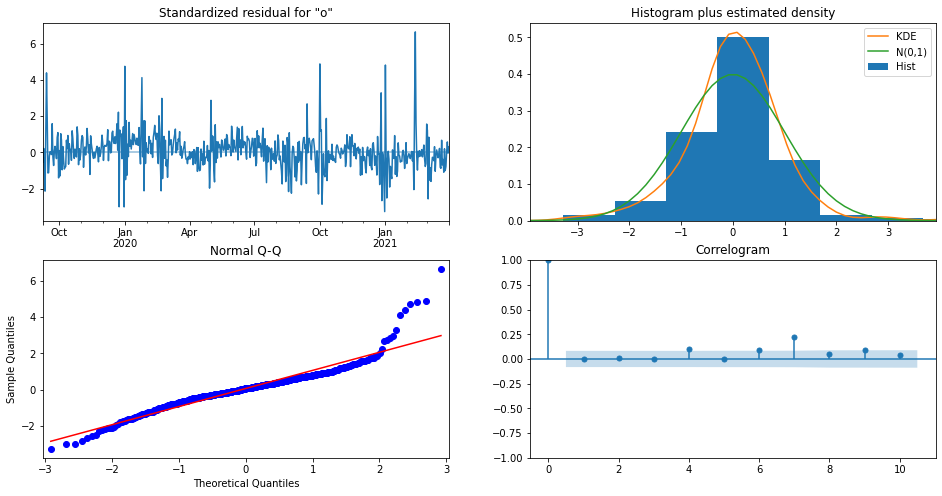

In [79]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()

### Step 4. 차량 수요 예측

In [80]:
pred_sarimax = res.get_forecast(len(y_test), exog=x_test).predicted_mean
sarimax_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, pred_sarimax))
pred_sarimax_ci = res.get_forecast(len(y_test), exog=x_test).conf_int()

In [81]:
print(f'Test RMSE: {sarimax_rmse}\n')

Test RMSE: 0.022558430425304775



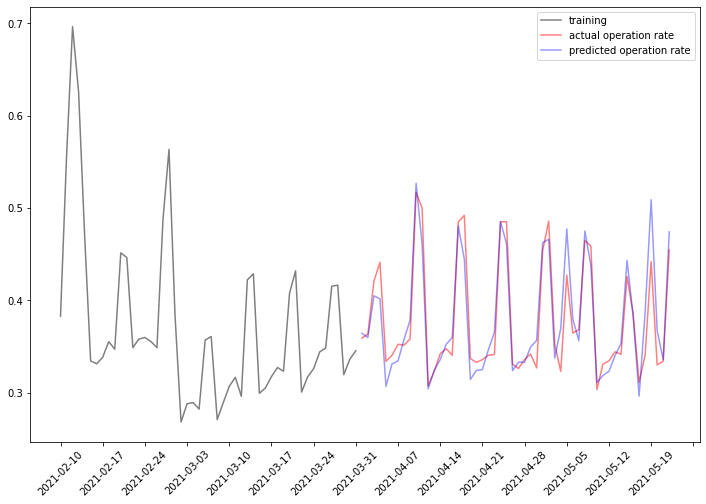

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(y_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(y_test.index.values, pred_sarimax, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

### Step 5. 다른 모형 사용하기

**1. RandomForestRegressor**

In [92]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
random_state = int(33)

In [101]:
rf_model = RandomForestRegressor(random_state=random_state)
rf_model.fit(X=x_train, y=y_train)

RandomForestRegressor(random_state=33)

In [111]:
y_rf_pred = rf_model.predict(X=x_test)
y_true = y_test

In [125]:
rf_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_rf_pred))
print(f'Test RMSE: {rf_rmse}\n')

Test RMSE: 0.019507572126603624



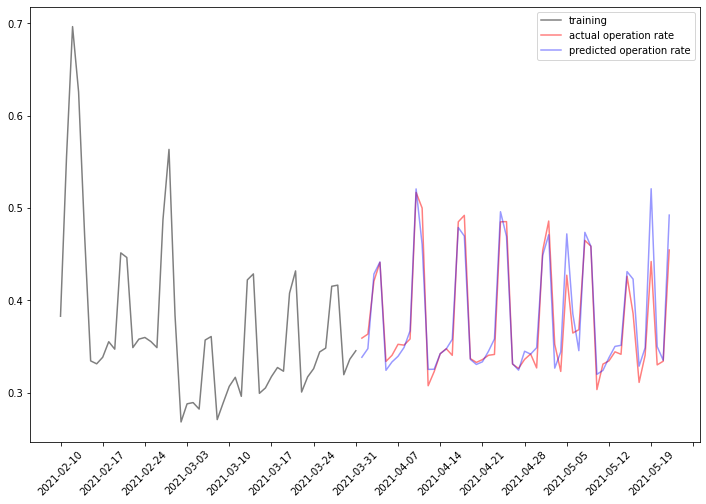

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(y_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(y_test.index.values, y_rf_pred, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

**2. LGBM**

In [105]:
from lightgbm import LGBMRegressor

random_state = int(33)

In [107]:
lgbm_model = LGBMRegressor(random_state=random_state)
lgbm_model.fit(X=x_train, y=y_train)

LGBMRegressor(random_state=33)

In [114]:
y_lgbm_pred = lgbm_model.predict(X=x_test)
y_true = y_test

In [122]:
lgbm_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_lgbm_pred))
print(f'Test RMSE: {lgbm_rmse}\n')

Test RMSE: 0.023250716422417043



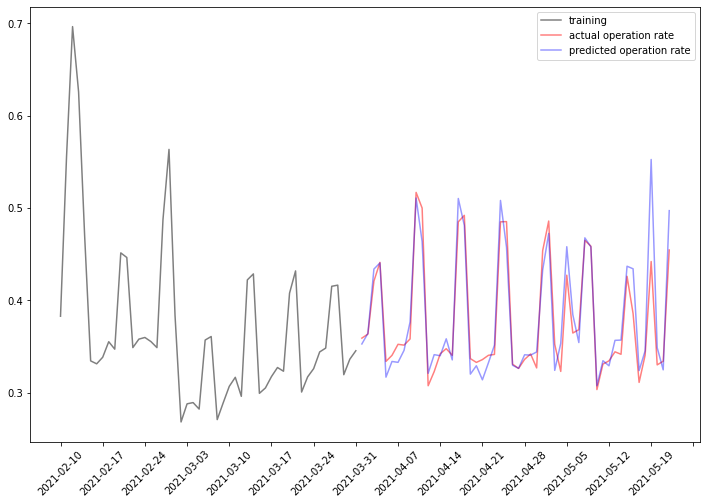

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(y_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(y_test.index.values, y_lgbm_pred, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

**3. Gradient Boosting**

In [117]:
from sklearn.ensemble import GradientBoostingRegressor

random_state = int(33)

In [119]:
gb_model = GradientBoostingRegressor(random_state=random_state)
gb_model.fit(X=x_train, y=y_train)

GradientBoostingRegressor(random_state=33)

In [120]:
y_gb_pred = gb_model.predict(X=x_test)
y_true = y_test

In [121]:
gb_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_gb_pred))
print(f'Test RMSE: {gb_rmse}\n')

Test RMSE: 0.020097731232925575



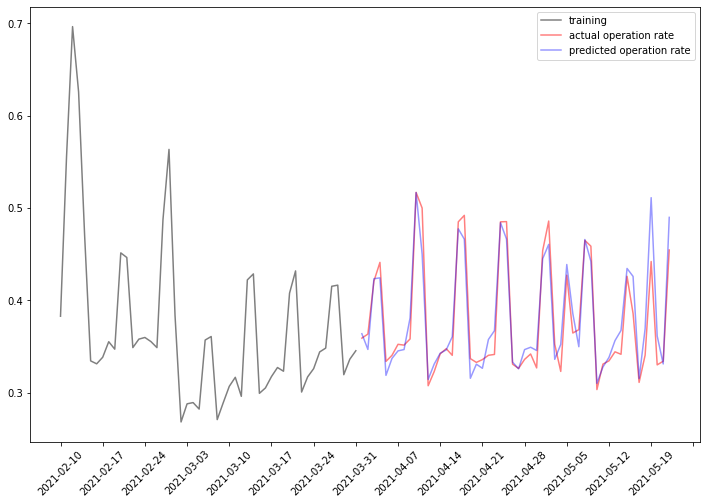

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(y_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(y_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(y_test.index.values, y_gb_pred, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

### Step 6. 결과 비교

In [128]:
sarimax_rmse

0.022558430425304775

In [130]:
model_rmse = pd.DataFrame({'Model':['SARIMAX', 'Random Forest', 'LGBM', 'Gradient Boosting'],
                             'RMSE':[round(sarimax_rmse, 5), round(rf_rmse, 5), round(lgbm_rmse, 5), round(gb_rmse, 5)]
                          })

In [132]:
model_rmse.sort_values('RMSE')

,Model,RMSE
1,Random Forest,0.01951
3,Gradient Boosting,0.02010
0,SARIMAX,0.02256
2,LGBM,0.02325


### 회고

: 사실 이번 노드는 그냥 분석 당했다는 표현이 맞는 거 같다. 노드에서 진행되었던 과정대로 전처리를 하고, 프로젝트 내용대로 그냥 프로젝트를 진행하고 결과다 나왔다. 다만 아쉬운 부분은 트리 구조의 모델을 사용할 때 그리드 서치를 통해 파라미터를 찾았으면 더 좋은 결과가 있을 법 했는데 그 과정을 스킵했던게 아쉬웠다. 이번 노드에서는 전반적으로 과정에 대한 이해도가 떨어져서 그냥 따라하는 정도의 결과밖에 안 나온 것 같다. 노드에서 나왔던 <https://otexts.com/fppkr/index.html> 시계열 데이터 자료를 토대로 정확하게 공부하고, 모델을 뜯어 본 후에 다시 프로젝트를 진행해 봐야 이해가 갈 것 같다.

추가로 그냥 모델에 데이터만 넣었을 뿐인데 그리드 서치까지 한 SARIMAX 보다 다른 모델들이 대체적으로 RMSE가 더 낮게 나온 게 의외다. 이 부분도 공부 후 모델을 뜯어보면 정리가 될 것 같다.